<a href="https://colab.research.google.com/github/Srikanth-Kb/CIFAR-10/blob/master/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!pip3 install torch torchvision

  Using cached https://files.pythonhosted.org/packages/14/41/db6dec65ddbc176a59b89485e8cc136a433ed9c6397b6bfe2cd38412051e/Pillow-6.1.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [115]:
transform_train = transforms.Compose([transforms.Resize((32,32)),transforms.RandomHorizontalFlip(),transforms.RandomRotation(10), transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset,batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image*np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck')

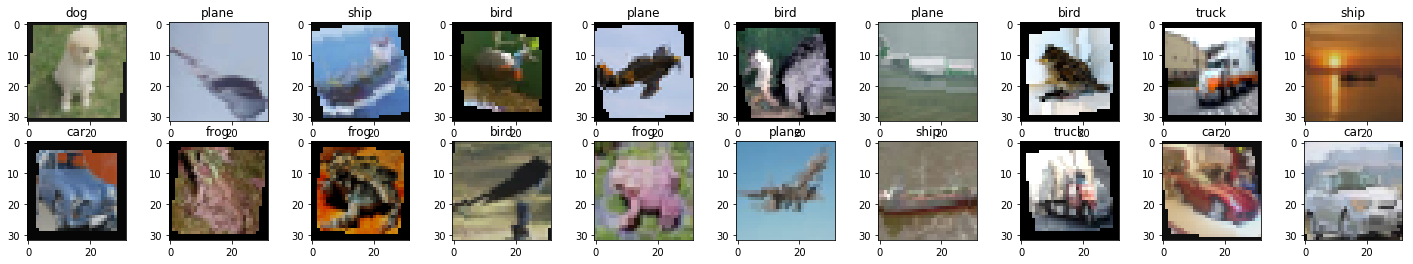

In [118]:
dataiter=iter(training_loader)
images,labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
  ax = fig.add_subplot(2,10,i+1)
  plt.imshow(im_convert(images[i]))
  ax.set_title(classes[labels[i].item()])
  


In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,3,1,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,1,padding=1)
    self.conv3 = nn.Conv2d(32,64,3,1,padding=1)
    self.fc1 = nn.Linear(4*4*64,500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x
    

In [120]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [122]:
epochs = 12
running_loss_history = []
running_correct_history = list()
validation_loss_history = []
validation_accuracy_history = []

for e in range(epochs):
  running_loss = 0.0 
  running_corrects = 0.0
  val_running_loss = 0.0  
  val_running_corrects = 0.0
  for inputs,labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, prediction = torch.max(outputs,1)
    running_corrects+=torch.sum(prediction == labels.data)
    running_loss+=loss.item()
  else:
    with torch.no_grad():
      
      for val_inputs,val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds= torch.max(val_outputs,1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds==val_labels.data)
        
    
    
    print('epoch number:',e+1)
    
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)
    print('training loss:{:.4f},acc:{:.4f}'.format(epoch_loss, epoch_acc.item()))
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    validation_loss_history.append(val_epoch_loss)
    validation_accuracy_history.append(val_epoch_acc)
    print('validation loss:{:.4f},acc:{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

    

epoch number: 1
training loss:1.6755,acc:38.3480
validation loss:1.3827,acc:49.9000
epoch number: 2
training loss:1.3800,acc:50.0900
validation loss:1.2262,acc:56.3900
epoch number: 3
training loss:1.2536,acc:54.9600
validation loss:1.1105,acc:59.8000
epoch number: 4
training loss:1.1656,acc:58.8680
validation loss:1.0478,acc:63.5100
epoch number: 5
training loss:1.0993,acc:61.0340
validation loss:0.9840,acc:65.1700
epoch number: 6
training loss:1.0531,acc:62.8320
validation loss:0.9396,acc:66.8900
epoch number: 7
training loss:1.0168,acc:64.1920
validation loss:0.9087,acc:68.2900
epoch number: 8
training loss:0.9819,acc:65.6140
validation loss:0.9131,acc:68.7000
epoch number: 9
training loss:0.9623,acc:66.2740
validation loss:0.8894,acc:69.2600
epoch number: 10
training loss:0.9344,acc:67.4300
validation loss:0.8569,acc:69.9500
epoch number: 11
training loss:0.9155,acc:67.9360
validation loss:0.8319,acc:71.0400
epoch number: 12
training loss:0.8987,acc:68.5200
validation loss:0.8281,a

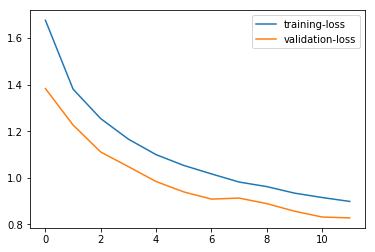

In [123]:
plt.plot(running_loss_history, label='training-loss')
plt.plot(validation_loss_history, label='validation-loss')
plt.legend()
        
        

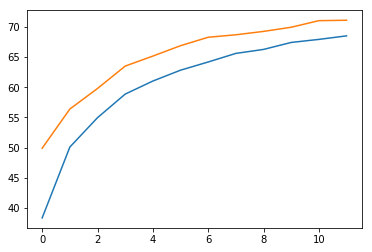

In [124]:
plt.plot(running_correct_history, label='training-accuracy')
plt.plot(validation_accuracy_history, label='validation-accuracy')


In [125]:
!pip3 install pillow==4.0.0

In [0]:
import PIL.ImageOps

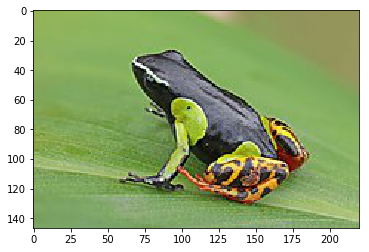

In [127]:
import requests
import PIL
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg/220px-Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg'
response = requests.get(url, stream=True)
img = PIL.Image.open(response.raw)
plt.imshow(img)

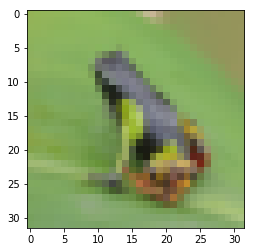

In [128]:
img = transform(img)
plt.imshow(im_convert(img))

In [129]:
image = img.to(device).unsqueeze(0)
output = model(image)
_,pred = torch.max(output,1)
print(classes[pred.item()])

bird


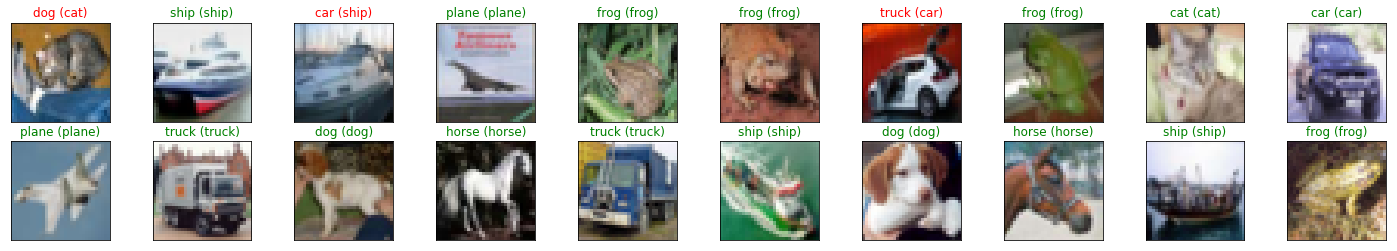

In [130]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))